# Сверточные нейронные сети (ноутбук)

> Знакомимся со сверточными нейронными сетями. Учимся решать задачу классификации изображений.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

warnings.filterwarnings('ignore')

plt.rc('font', size=30)

## Opencv
Библиотека для удобной работы с картинками

## Загрузка изображения

Загрузим изображение из интернета, например, мем про юккури.

In [2]:
! wget "https://static.wikia.nocookie.net/yukkuri/images/f/fc/Take_It_Easy!.jpg" -O yukkuri.jpg

--2023-10-20 18:43:22--  https://static.wikia.nocookie.net/yukkuri/images/f/fc/Take_It_Easy!.jpg
Resolving static.wikia.nocookie.net (static.wikia.nocookie.net)... 74.120.190.194, 74.120.190.204
Connecting to static.wikia.nocookie.net (static.wikia.nocookie.net)|74.120.190.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119810 (117K) [image/jpeg]
Saving to: ‘yukkuri.jpg’

yukkuri.jpg         100%[===================>] 117.00K   248KB/s    in 0.5s    

2023-10-20 18:43:24 (248 KB/s) - ‘yukkuri.jpg’ saved [119810/119810]



## Чтение изображения

In [3]:
img = Image.open('yukkuri.jpg')

In [4]:
img.format

'JPEG'

In [5]:
img.size

(600, 334)

In [6]:
img.mode

'RGB'

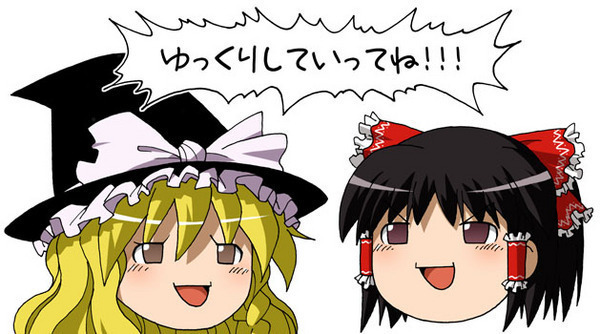

In [7]:
img

## Матричное представление

In [8]:
img_matrix = np.array(img)

In [ ]:
img_matrix = img

In [9]:
img_matrix.shape

(334, 600, 3)

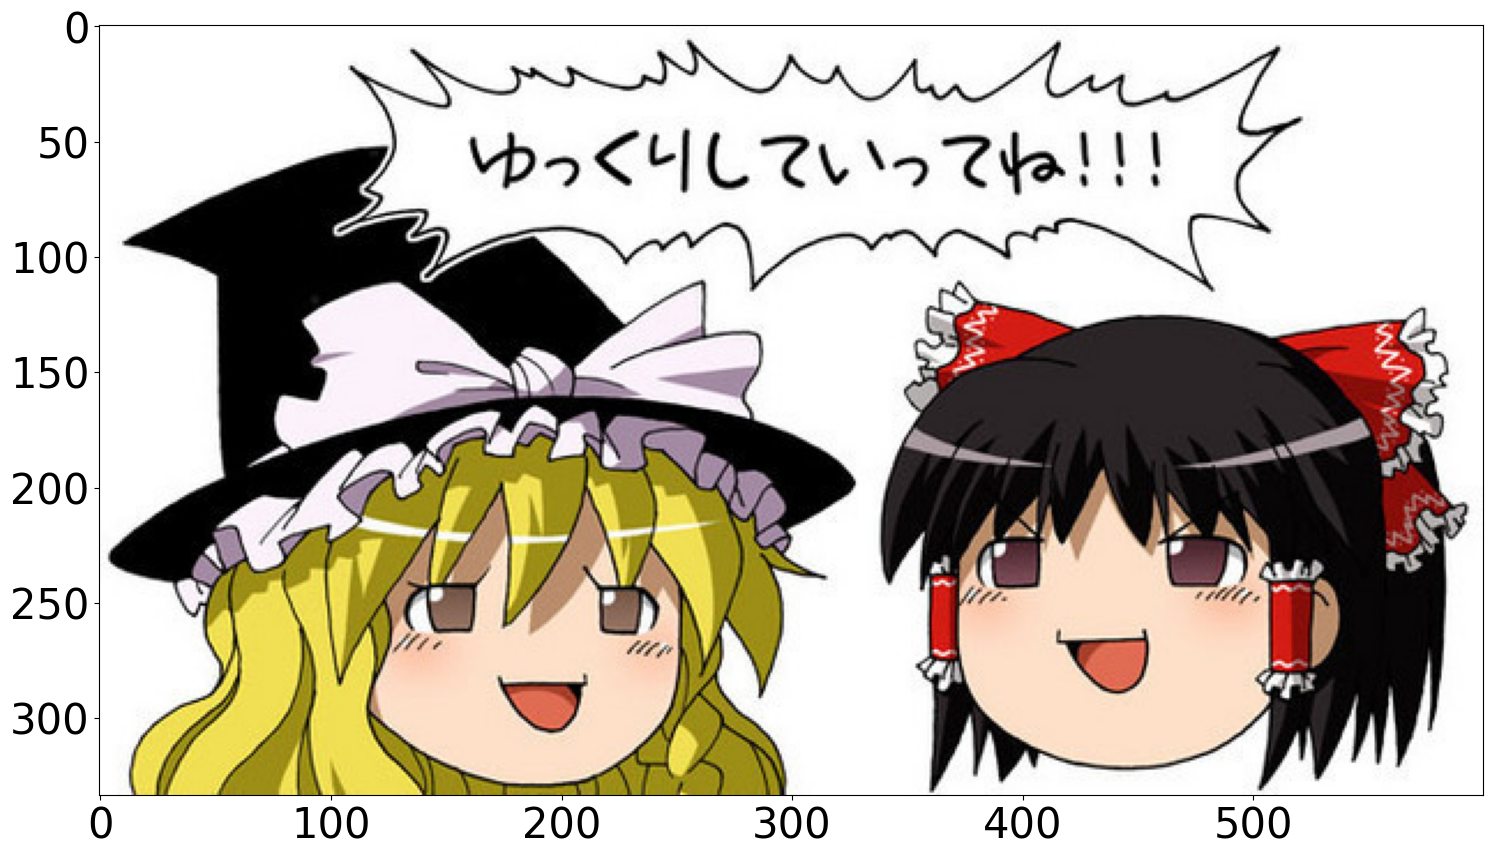

In [10]:
plt.figure(figsize=(20, 10))

plt.imshow(img_matrix)

plt.show()

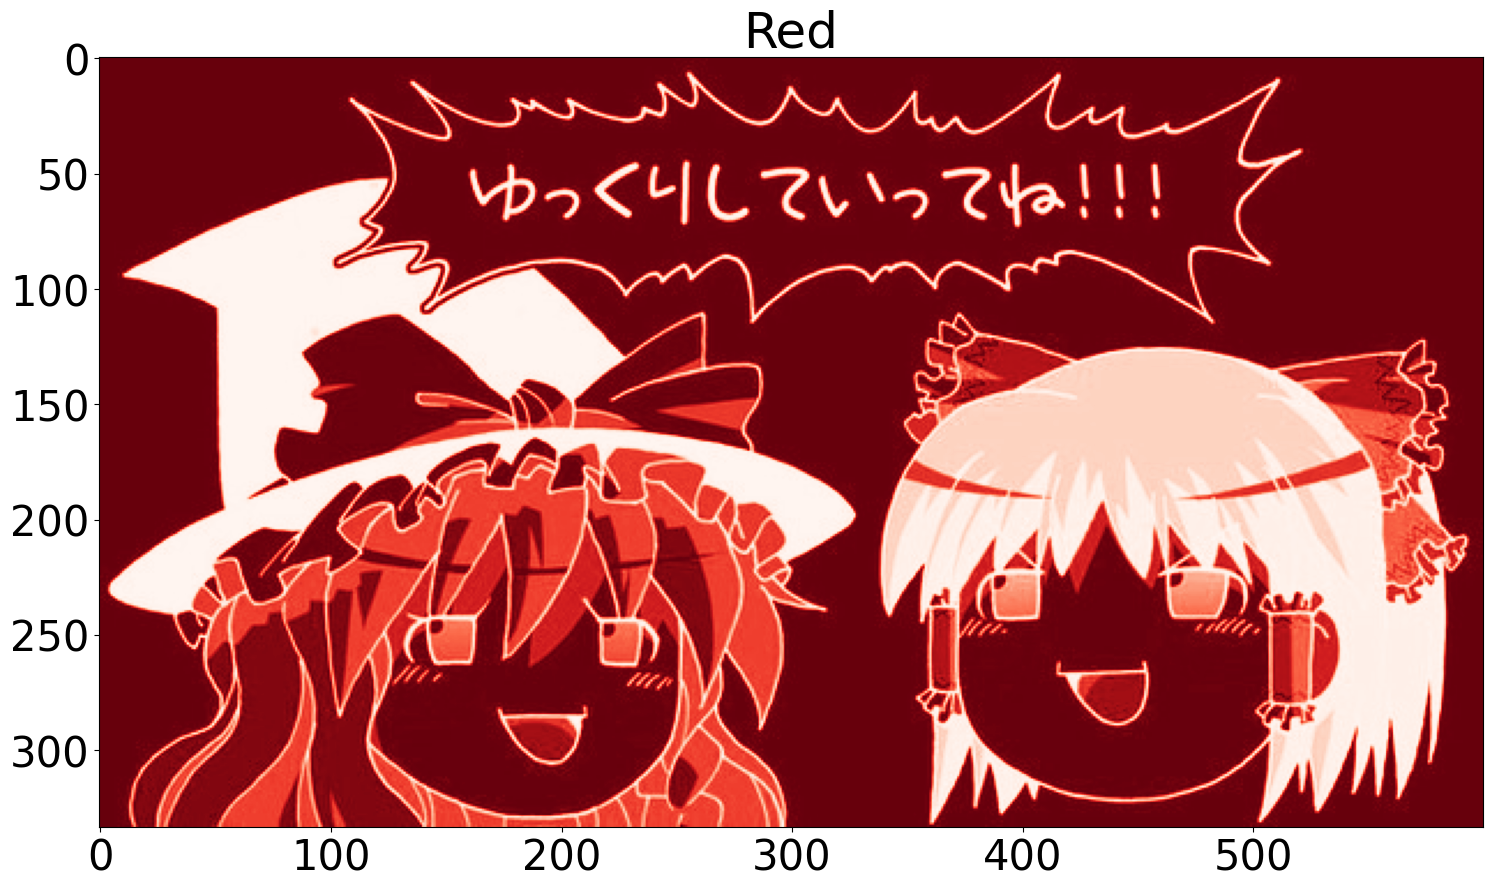

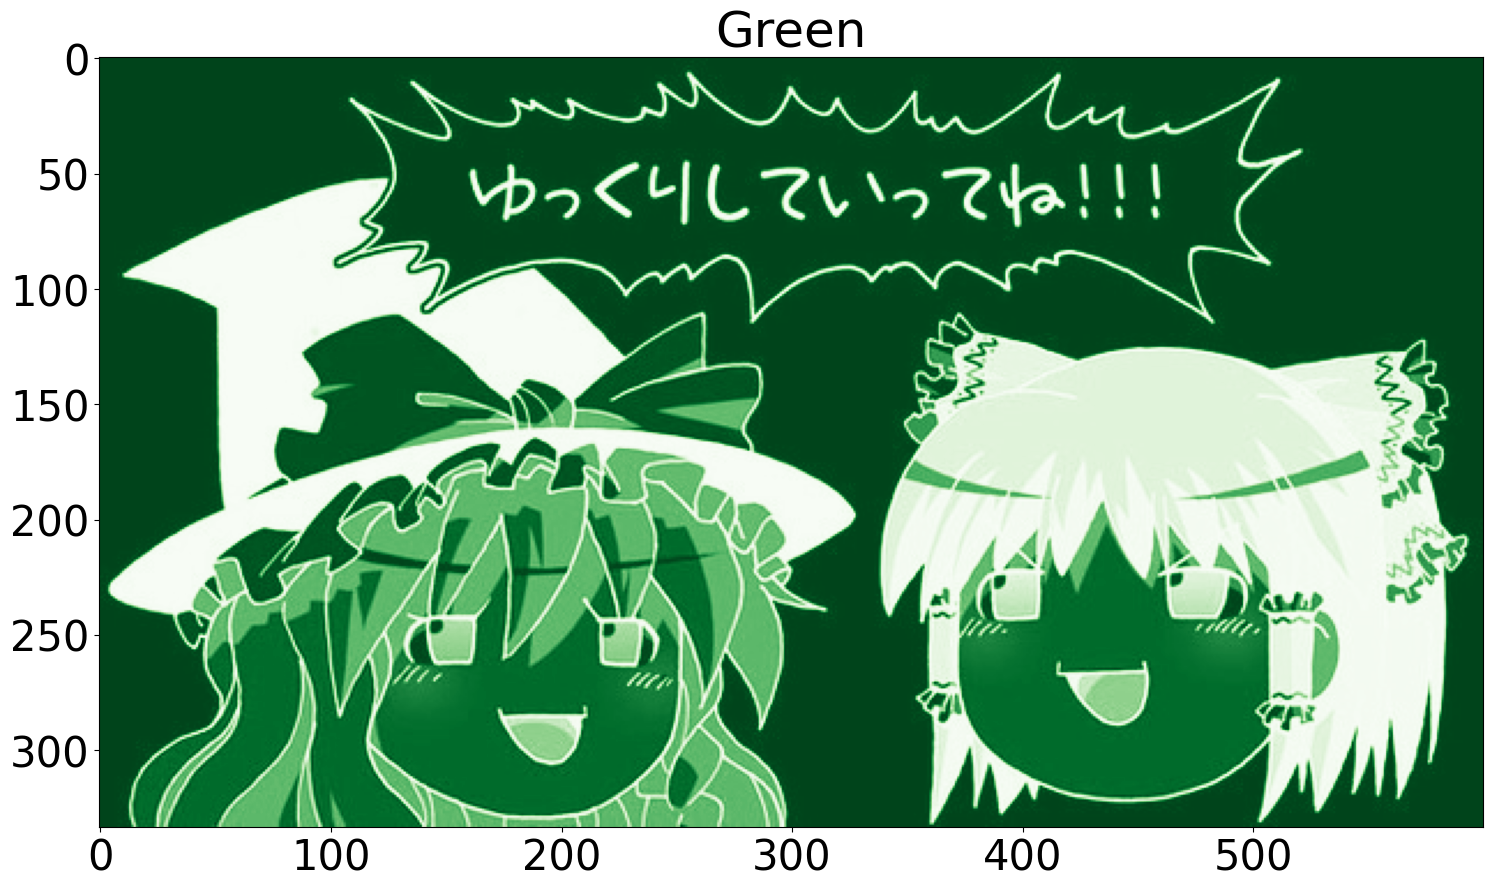

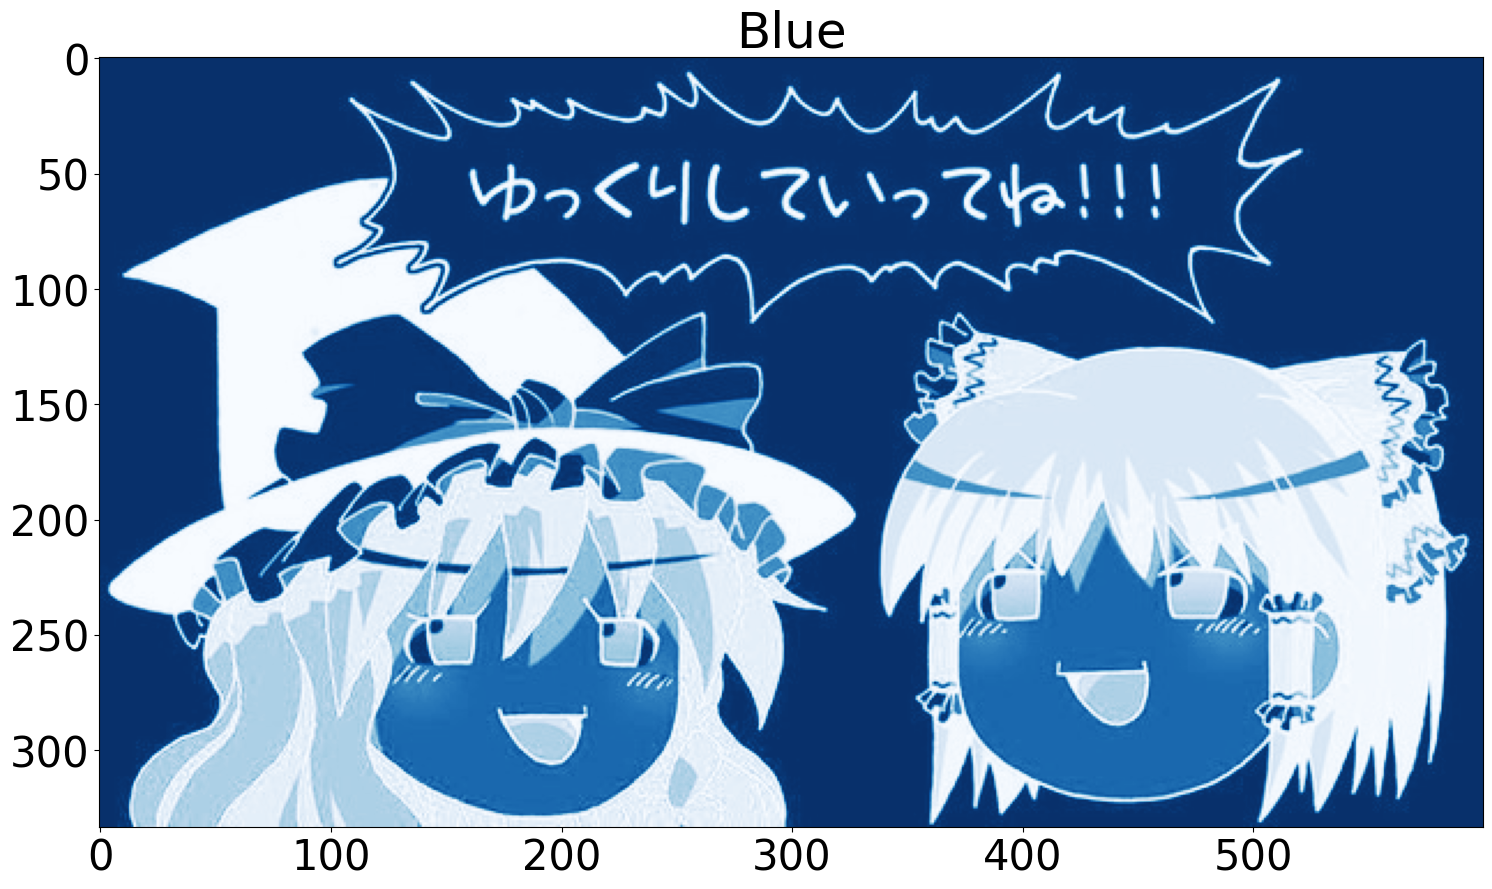

In [11]:
for i, (cmap, color) in enumerate(
    zip(
        [cm.Reds, cm.Greens, cm.Blues],
        ['Red', 'Green', 'Blue']
    )
):
    plt.figure(figsize=(20, 10))
    plt.imshow(img_matrix[:, :, i], cmap=cmap)
    plt.title(color)
    plt.show()

In [12]:
img_matrix[:, :, 0].min(), img_matrix[:, :, 0].max()

(0, 255)

In [13]:
img_matrix

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

## Свертка

Свертка в `PyTorch` представлена модулем `nn.Conv2d` со следующими параметрами:

- in_channels (int) – Количество каналов во входном изображении

- out_channels (int) – Количество каналов в выходном изображении

- kernel_size (int or tuple) – Размер ядра свертки

- stride (int or tuple, optional) – Страйд (шаг ядра свертки). По умолчанию: 1

- padding (int, tuple or str, optional) – Размер паддинга. По умолчанию: 0

- padding_mode (string, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. По умолчанию: 'zeros'

- dilation (int or tuple, optional) – Дилейшн (шаг между элементами внутри ядра). По умолчанию: 1

- bias (bool, optional) – добавлять ли обучаемый сдвиг. По умолчанию: True

In [14]:
conv1 = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3
)

In [15]:
conv1.weight

Parameter containing:
tensor([[[[ 1.0634e-01,  1.7636e-01, -1.9169e-02],
          [-1.5154e-01,  4.9168e-02, -6.3701e-02],
          [-3.1268e-02,  1.8447e-01,  1.5059e-01]],

         [[-1.8232e-01, -1.1176e-01, -1.3574e-01],
          [-1.5026e-01, -1.8116e-01, -4.0262e-03],
          [-1.6213e-01, -3.1168e-02,  1.6824e-01]],

         [[-5.0274e-02, -3.6611e-02, -1.2118e-02],
          [ 7.1104e-02,  9.4521e-03, -1.0685e-01],
          [ 3.7602e-02, -1.0307e-02,  1.5691e-01]]],


        [[[-5.7869e-02,  1.3344e-01, -2.0699e-02],
          [-3.5015e-02, -1.6812e-01, -1.1280e-02],
          [ 1.2459e-01, -1.4688e-01, -1.7154e-01]],

         [[-1.6230e-01,  1.3655e-01,  4.5340e-02],
          [ 5.5335e-02,  9.2459e-02, -8.2263e-02],
          [-1.3362e-01,  2.9375e-02,  7.8758e-02]],

         [[-7.2943e-02, -1.0311e-01, -9.8511e-02],
          [ 1.2131e-01,  1.7468e-01,  1.1736e-01],
          [ 1.2432e-01,  8.5325e-02,  6.8944e-02]]],


        [[[ 1.1379e-01,  7.8202e-02,  1.4829

In [17]:
img_tensor = T.ToTensor()(img).unsqueeze(0)

In [18]:
img_tensor.shape

torch.Size([1, 3, 334, 600])

In [20]:
output = conv1(img_tensor)

In [21]:
output.shape

torch.Size([1, 10, 332, 598])

In [22]:
conv2 = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
    padding=1
)

In [23]:
output = conv2(img_tensor)

In [24]:
output.shape

torch.Size([1, 10, 334, 600])

In [25]:
conv2(output)

RuntimeError: Given groups=1, weight of size [10, 3, 3, 3], expected input[1, 10, 334, 600] to have 3 channels, but got 10 channels instead

## Пулинг

Пулинг представлен в модуле `torch.nn`, в основном будем использовать `MaxPool2d` и `AvgPool2d`.

Параметры:

- kernel_size – размер окошка

- stride – страйд окошка. По умолчанию равен kernel_size

- padding – сколько нулевого паддинга добавлять по краям. По умолчанию: 0.

In [26]:
img_tensor = torch.randint(0, 10, size=(10, 10), dtype=torch.float32).unsqueeze(0)

In [27]:
img_tensor

tensor([[[4., 8., 6., 2., 6., 8., 9., 9., 9., 1.],
         [6., 3., 7., 0., 5., 5., 0., 3., 1., 3.],
         [8., 1., 3., 7., 7., 0., 5., 7., 4., 5.],
         [1., 6., 8., 9., 8., 1., 1., 6., 0., 1.],
         [2., 6., 5., 2., 7., 8., 0., 4., 5., 9.],
         [7., 4., 1., 1., 6., 5., 0., 8., 4., 6.],
         [2., 4., 6., 3., 9., 1., 8., 3., 0., 2.],
         [9., 2., 5., 5., 2., 3., 4., 2., 7., 3.],
         [4., 0., 1., 6., 5., 5., 2., 2., 1., 3.],
         [9., 8., 3., 8., 3., 1., 8., 1., 2., 8.]]])

In [28]:
pooling1 = nn.MaxPool2d(kernel_size=2)

In [29]:
pooling1(img_tensor)

tensor([[[8., 7., 8., 9., 9.],
         [8., 9., 8., 7., 5.],
         [7., 5., 8., 8., 9.],
         [9., 6., 9., 8., 7.],
         [9., 8., 5., 8., 8.]]])

In [30]:
pooling2 = nn.AvgPool2d(kernel_size=2)

In [31]:
pooling2(img_tensor)

tensor([[[5.2500, 3.7500, 6.0000, 5.2500, 3.5000],
         [4.0000, 6.7500, 4.0000, 4.7500, 2.5000],
         [4.7500, 2.2500, 6.5000, 3.0000, 6.0000],
         [4.2500, 4.7500, 3.7500, 4.2500, 3.0000],
         [5.2500, 4.5000, 3.5000, 3.2500, 3.5000]]])

## Датасет MNIST

In [32]:
mnist_train = MNIST(
    "../../datasets/mnist",
    train=False,
    download=True

)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../datasets/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../datasets/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../datasets/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../datasets/mnist/MNIST/raw



In [33]:
mnist_train.data.shape

torch.Size([10000, 28, 28])

In [34]:
mnist_train.test_labels.shape

torch.Size([10000])

In [35]:
mnist_train[0][0]

In [36]:
mnist_train = MNIST(
    "../../datasets/mnist",
    train=True,
    download=True,
    transform=T.Compose([T.ToTensor(), T.Resize(28)])
)

In [37]:
mnist_valid = MNIST(
    "../../datasets/mnist",
    train=False,
    download=True,
    transform=T.ToTensor()
)

In [38]:
len(mnist_train)

60000

In [39]:
len(mnist_valid)

10000

In [40]:
from torch.utils.data import ConcatDataset

train_loader = DataLoader(ConcatDataset((mnist_train, mnist_valid)), batch_size=64, shuffle=True)
valid_loader = DataLoader(mnist_valid, batch_size=64, shuffle=False)

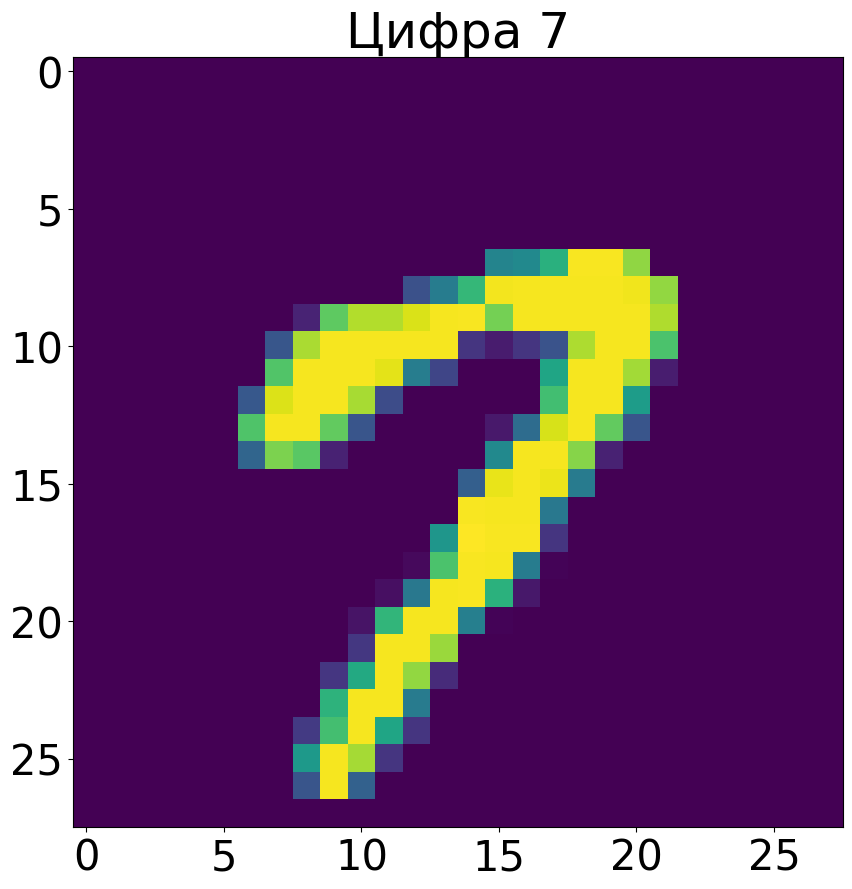

In [41]:
plt.figure(figsize=(10, 10))
plt.title(f'Цифра {mnist_train[15][1]}')
plt.imshow(mnist_train[15][0][0])

plt.show()

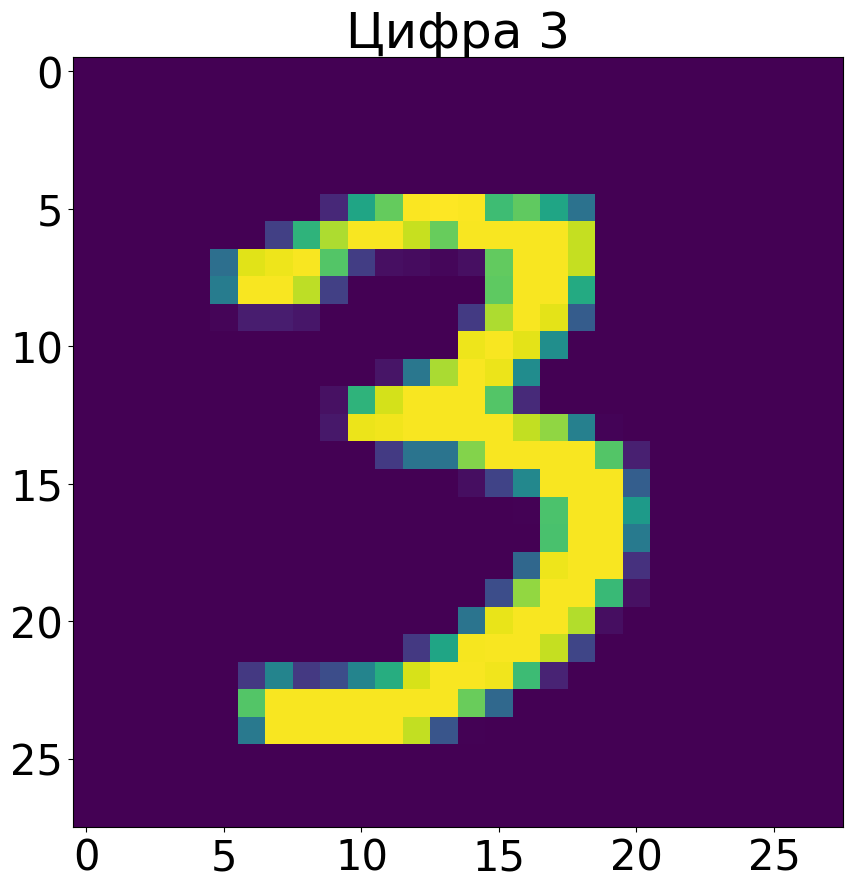

In [42]:
plt.figure(figsize=(10, 10))
plt.title(f'Цифра {mnist_train[10000][1]}')
plt.imshow(mnist_train[10000][0][0])

plt.show()

## Полносвязная нейронная сеть

Обучим полносвязную нейронную сеть на датасете MNIST.

In [43]:
def train(model: nn.Module) -> float:
    model.train()

    train_loss = 0

    for x, y in tqdm(train_loader, desc='Train'):
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    
    return train_loss

In [44]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [48]:
def plot_stats(
    train_loss,
    valid_loss,
    valid_accuracy,
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' valid accuracy')

    plt.plot(valid_accuracy)
    plt.grid()

    plt.show()

In [63]:
first_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
)

optimizer = torch.optim.Adam(first_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

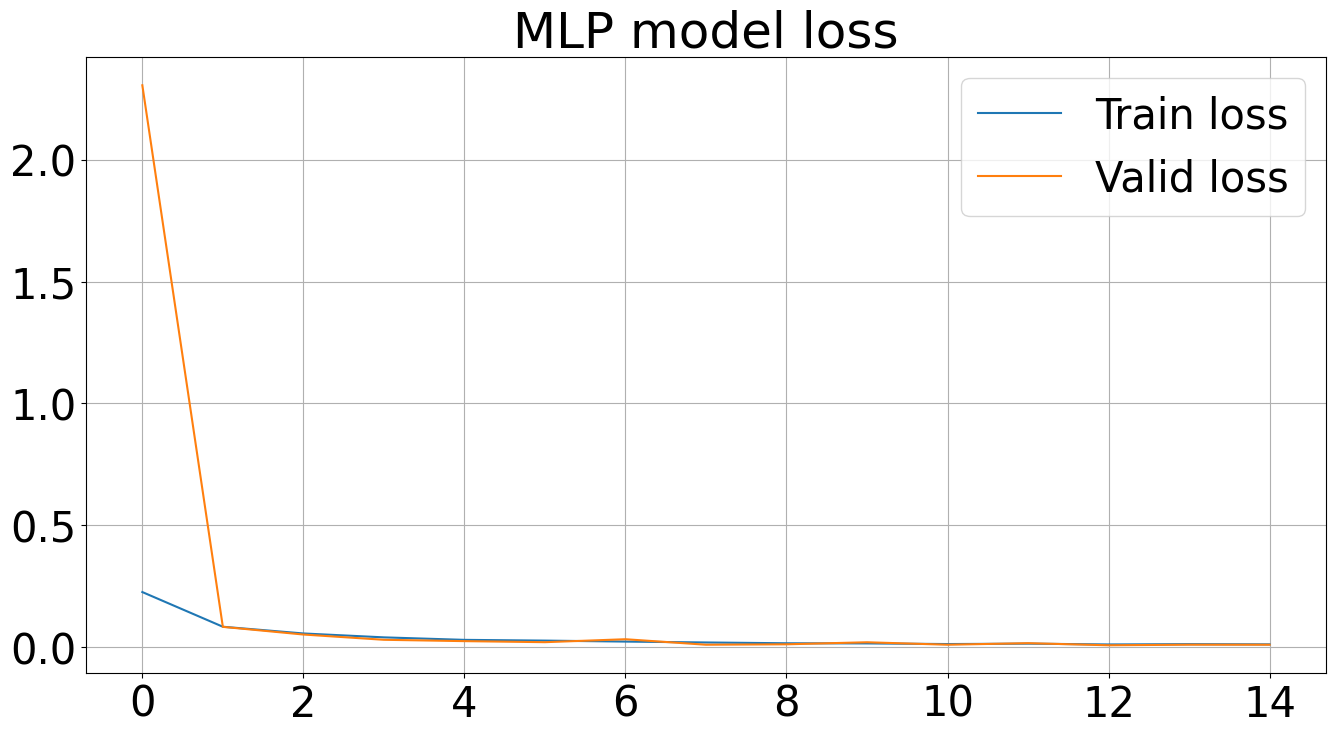

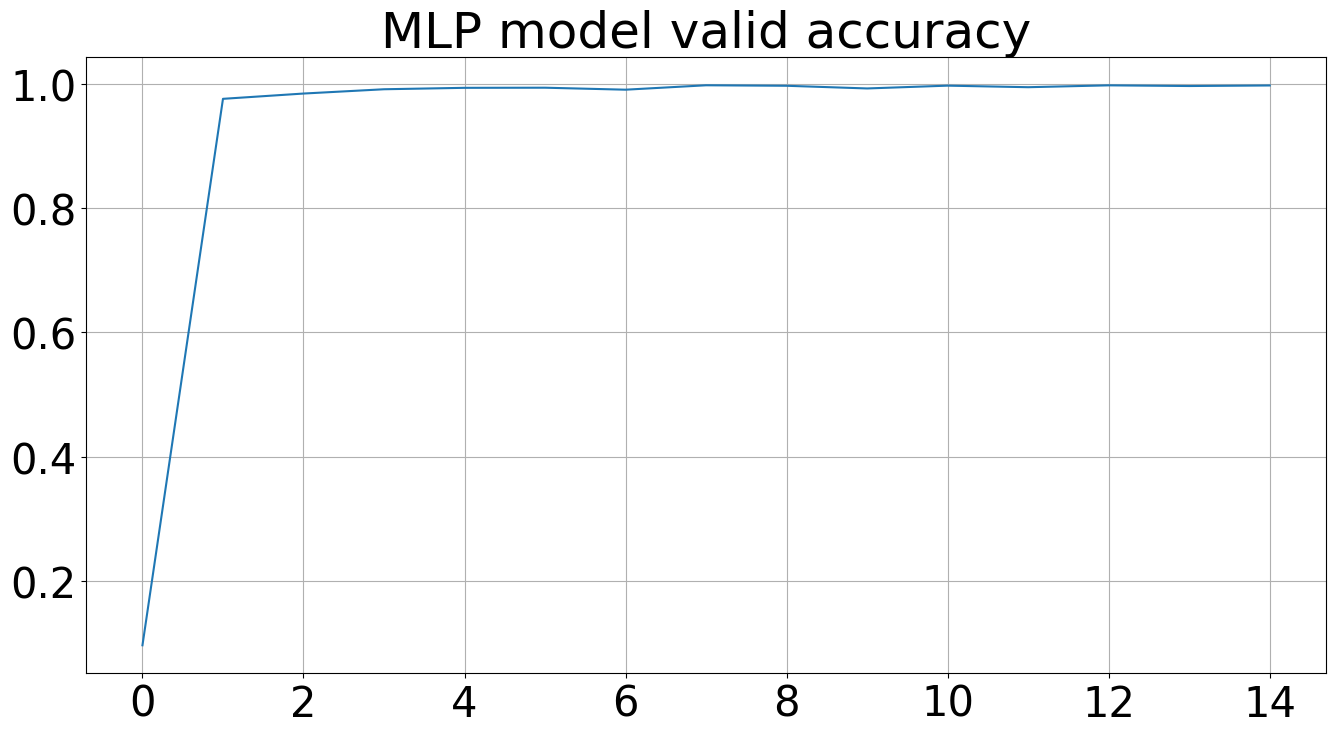

Evaluation: 100%|██████████| 157/157 [00:00<00:00, 624.31it/s]

Total training and evaluation time 93.32591


In [64]:
num_epochs = 15

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    valid_loss, valid_accuracy = evaluate(first_model, valid_loader)
    
    train_loss = train(first_model)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)=
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'MLP model')
    

valid_loss, valid_accuracy = evaluate(first_model, valid_loader)
    
print(f'Total training and evaluation time {perf_counter() - start:.5f}')

## Сверточная сеть

In [49]:
second_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5), #28*28
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2), #14*14

    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2),
    
    nn.Flatten(),
    nn.Linear(4 * 4 * 16, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 10))


x = torch.rand((1, 1, 28, 28))
print(x.shape)
print(second_model(x).shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 10])


In [50]:
second_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5), #28*28
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2), #14*14

    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.Linear(4 * 4 * 16, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 10)
)

optimizer = torch.optim.Adam(second_model.parameters(), lr=7e-4)

loss_fn = nn.CrossEntropyLoss()

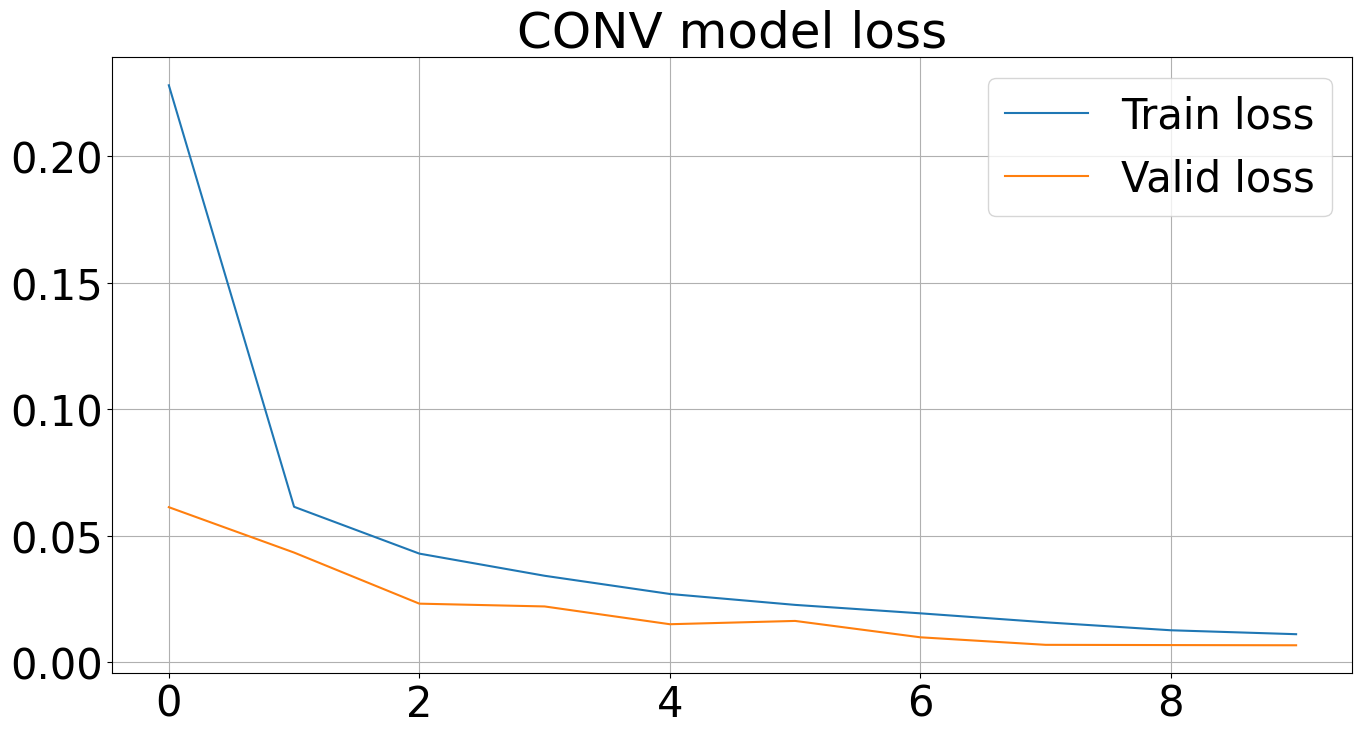

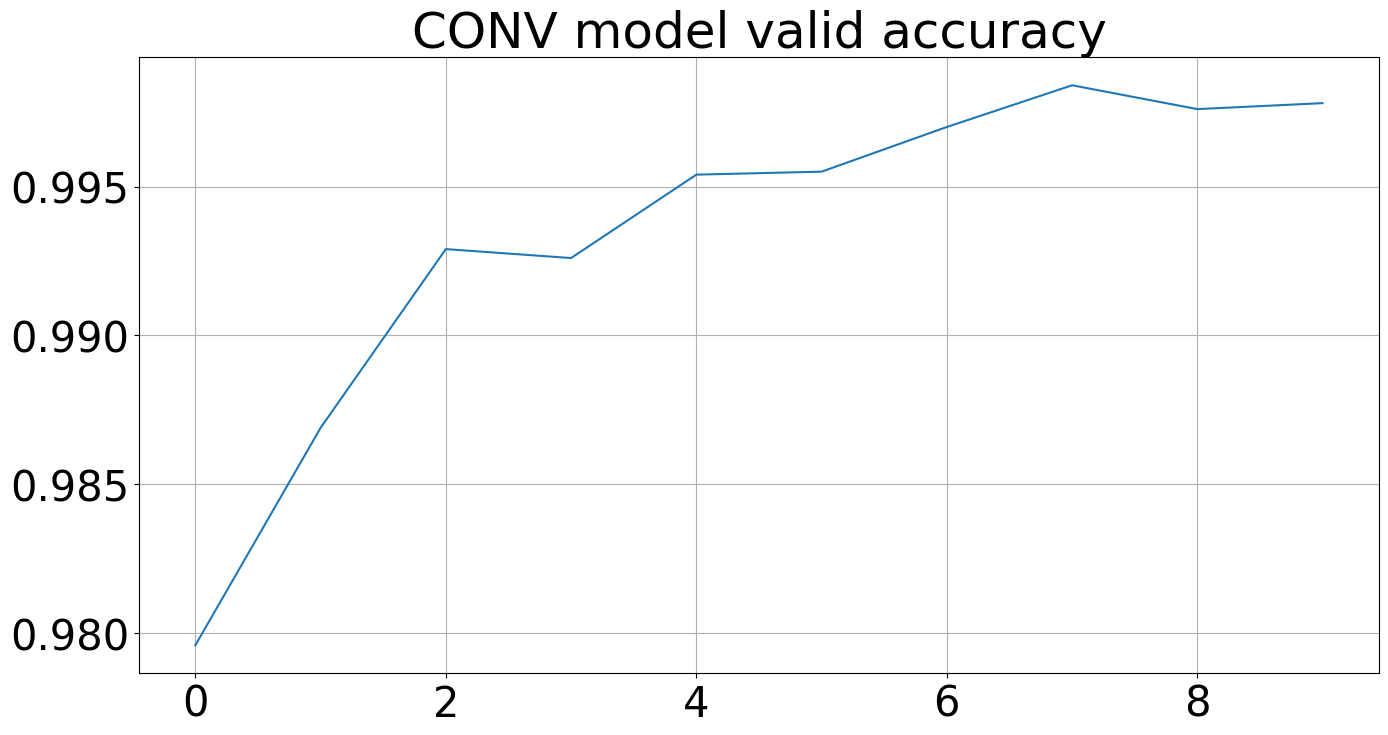

Total training and evaluation time 73.62876


In [51]:
num_epochs = 10

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(second_model)

    valid_loss, valid_accuracy = evaluate(second_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'CONV model')

print(f'Total training and evaluation time {perf_counter() - start:.5f}')

In [55]:
second_model.eval()

with torch.no_grad():
    for img, cls in valid_loader:
        print("predicted", torch.argmax(second_model(img)[:20], dim=1))
        print("true     ", cls[:20])

predicted tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])
true      tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])
predicted tensor([7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7])
true      tensor([7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7])
predicted tensor([8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2])
true      tensor([8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2])
predicted tensor([0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5])
true      tensor([0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5])
predicted tensor([2, 8, 2, 6, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4])
true      tensor([2, 8, 2, 6, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4])
predicted tensor([9, 2, 9, 3, 0, 4, 2, 0, 7, 1, 1, 2, 1, 5, 3, 3, 9, 7, 8, 6])
true      tensor([9, 2, 9, 3, 0, 4, 2, 0, 7, 1, 1, 2, 1, 5, 3, 3, 9, 7, 8, 6])
predicted tensor([6, 1, 6, 2, 1, 9, 2, 8, 6, 1, 9, 5

predicted tensor([2, 7, 7, 4, 0, 2, 4, 2, 1, 8, 9, 6, 1, 0, 5, 9, 6, 9, 8, 0])
true      tensor([2, 7, 7, 4, 0, 2, 4, 2, 1, 8, 9, 6, 1, 0, 5, 9, 6, 9, 8, 0])
predicted tensor([8, 3, 1, 5, 8, 2, 7, 4, 2, 1, 5, 4, 5, 5, 8, 6, 4, 4, 4, 1])
true      tensor([8, 3, 1, 5, 8, 2, 7, 4, 2, 1, 5, 4, 5, 5, 8, 6, 4, 4, 4, 1])
predicted tensor([3, 0, 2, 0, 1, 0, 1, 0, 4, 0, 1, 0, 4, 7, 9, 6, 2, 6, 2, 2])
true      tensor([3, 0, 2, 0, 1, 0, 1, 0, 4, 0, 1, 0, 4, 7, 9, 6, 2, 6, 2, 2])
predicted tensor([4, 7, 1, 9, 1, 7, 1, 4, 0, 0, 4, 1, 7, 5, 7, 1, 3, 3, 3, 1])
true      tensor([4, 7, 1, 9, 1, 7, 1, 4, 0, 0, 4, 1, 7, 5, 7, 1, 3, 3, 3, 1])
predicted tensor([8, 9, 6, 8, 8, 2, 3, 6, 1, 2, 9, 8, 9, 5, 2, 6, 2, 4, 8, 4])
true      tensor([8, 9, 6, 8, 8, 2, 3, 6, 1, 2, 9, 8, 9, 5, 2, 6, 2, 4, 8, 4])
predicted tensor([4, 6, 1, 0, 4, 5, 3, 9, 4, 2, 5, 5, 0, 1, 3, 2, 9, 1, 6, 0])
true      tensor([4, 6, 1, 0, 4, 5, 3, 9, 4, 2, 0, 5, 0, 1, 3, 2, 9, 1, 6, 0])
predicted tensor([3, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2

На семинаре был вопрос про то, можно ли заменить пулинг сверткой.
Ответ: можно, но не всегда нужно. Пулинг это операция (если maxpool то еще и нелинейная), в которой ничего не учится, но она отлично помогает уменьшить размер картинки и доказала свою эффективность во многих нейронках. Свертки - более сложные и ресурсозатратные слои с обучаемыми весами.  \\
Попробуем  
1)заменить пулинги слоем свертка + активация (чтобы смоделировать нелинейность) и также просто расширим в сети число пара
2) просто удалим пулинги, а ядро в предыдущей перед ним свертке увеличим в 2 раза и добавим страйд 2

In [57]:
second_model_replaced_pool = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=10, padding=2, stride=2), #28*28
    nn.LeakyReLU(), #если ее не поставим, то получится просто 

    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=10, padding=2, stride=2),
    nn.LeakyReLU(),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=2, stride=2, padding=0),
    nn.LeakyReLU())
x = torch.rand((1, 1, 28, 28))
second_model_replaced_pool(x).shape

torch.Size([1, 16, 2, 2])

In [58]:
second_model_replaced_pool_with_conv_lrelu = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5), #28*28
    nn.LeakyReLU(),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=2, stride=2, padding=0),
    nn.LeakyReLU(),

    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5),
    nn.LeakyReLU(),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=2, stride=2, padding=0),
    nn.LeakyReLU(),

    nn.Flatten(),
    nn.Linear(4 * 4 * 16, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 10)
)

optimizer = torch.optim.Adam(second_model_replaced_pool_with_conv_lrelu.parameters(), lr=7e-4)

loss_fn = nn.CrossEntropyLoss()

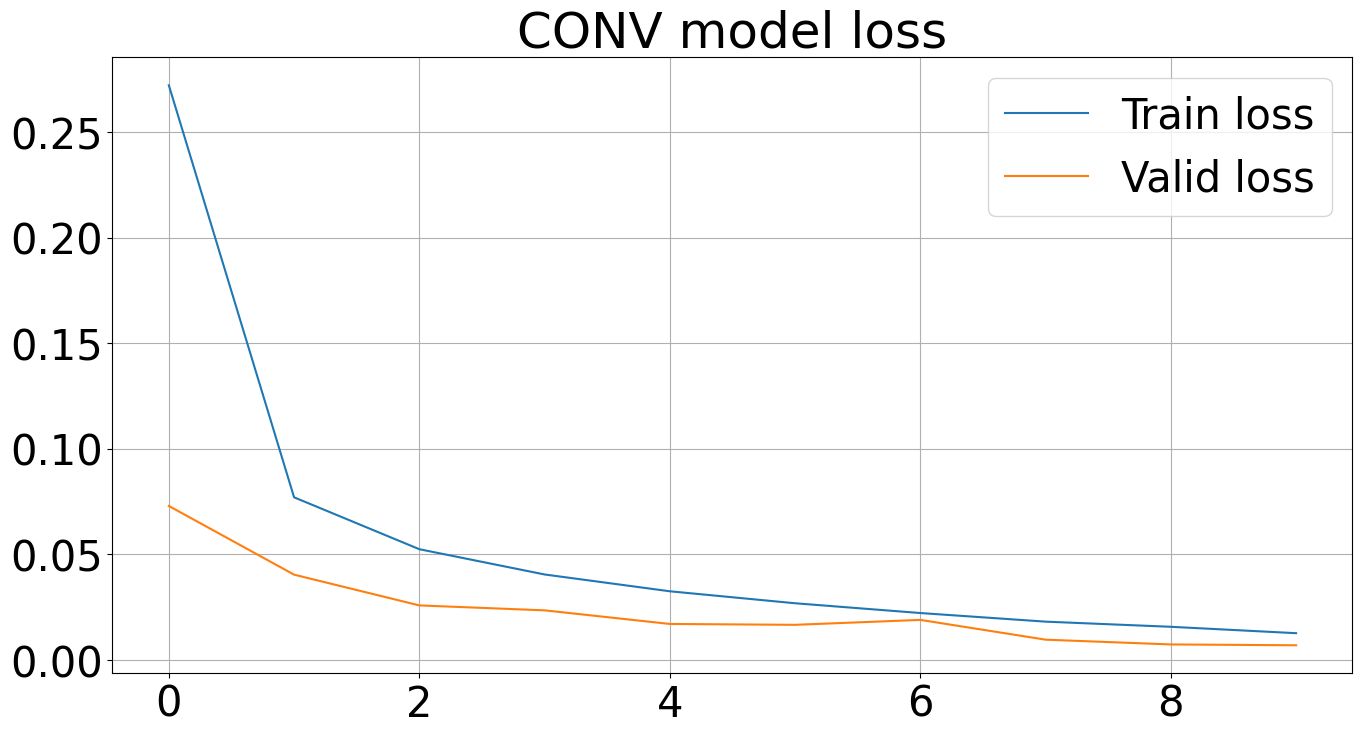

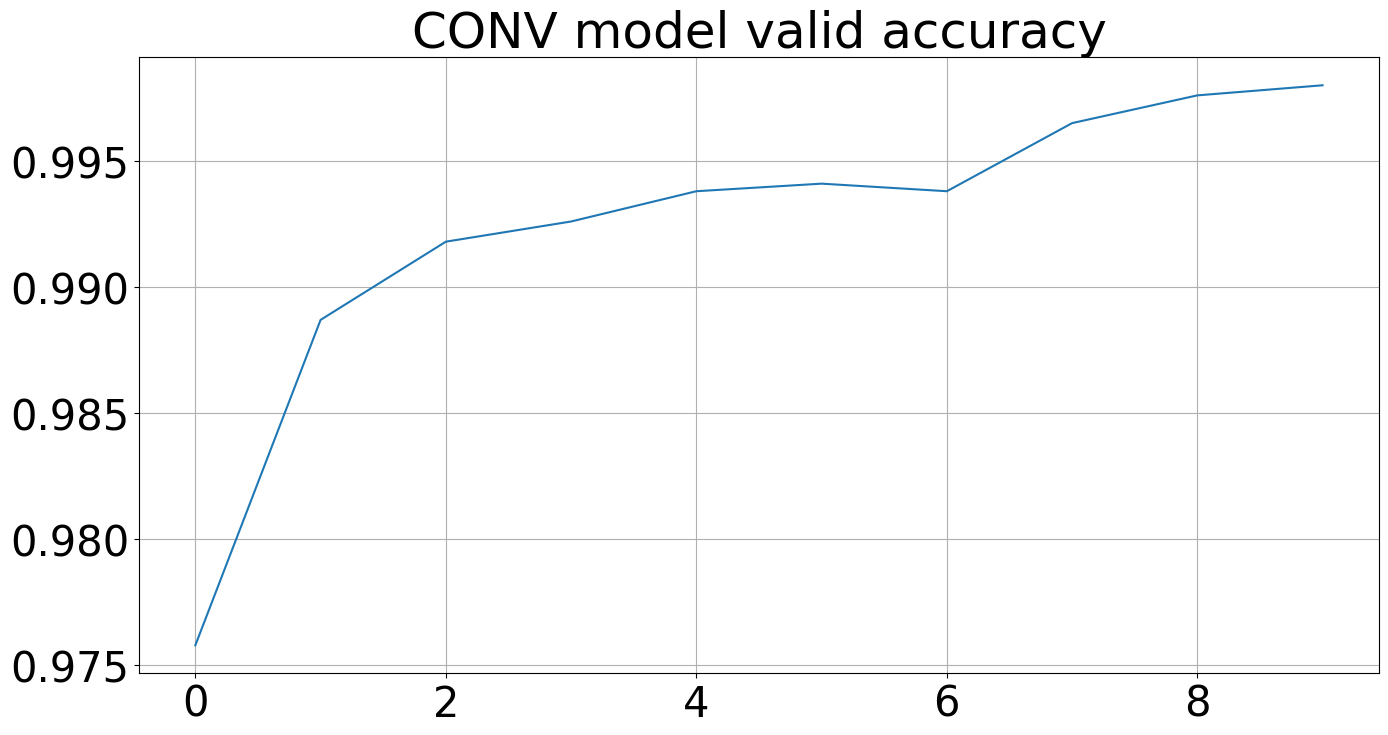

Total training and evaluation time 79.17762


In [59]:
num_epochs = 10

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(second_model_replaced_pool_with_conv_lrelu)

    valid_loss, valid_accuracy = evaluate(second_model_replaced_pool_with_conv_lrelu, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'CONV model')

print(f'Total training and evaluation time {perf_counter() - start:.5f}')

In [60]:
second_model_del_maxpool = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=2), #28*28
    nn.LeakyReLU(),
    # nn.MaxPool2d(kernel_size=2), #14*14

    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=2),
    nn.LeakyReLU(),
    # nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.Linear(4 * 4 * 16, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 10)
)

optimizer = torch.optim.Adam(second_model_del_maxpool.parameters(), lr=7e-4)

loss_fn = nn.CrossEntropyLoss()

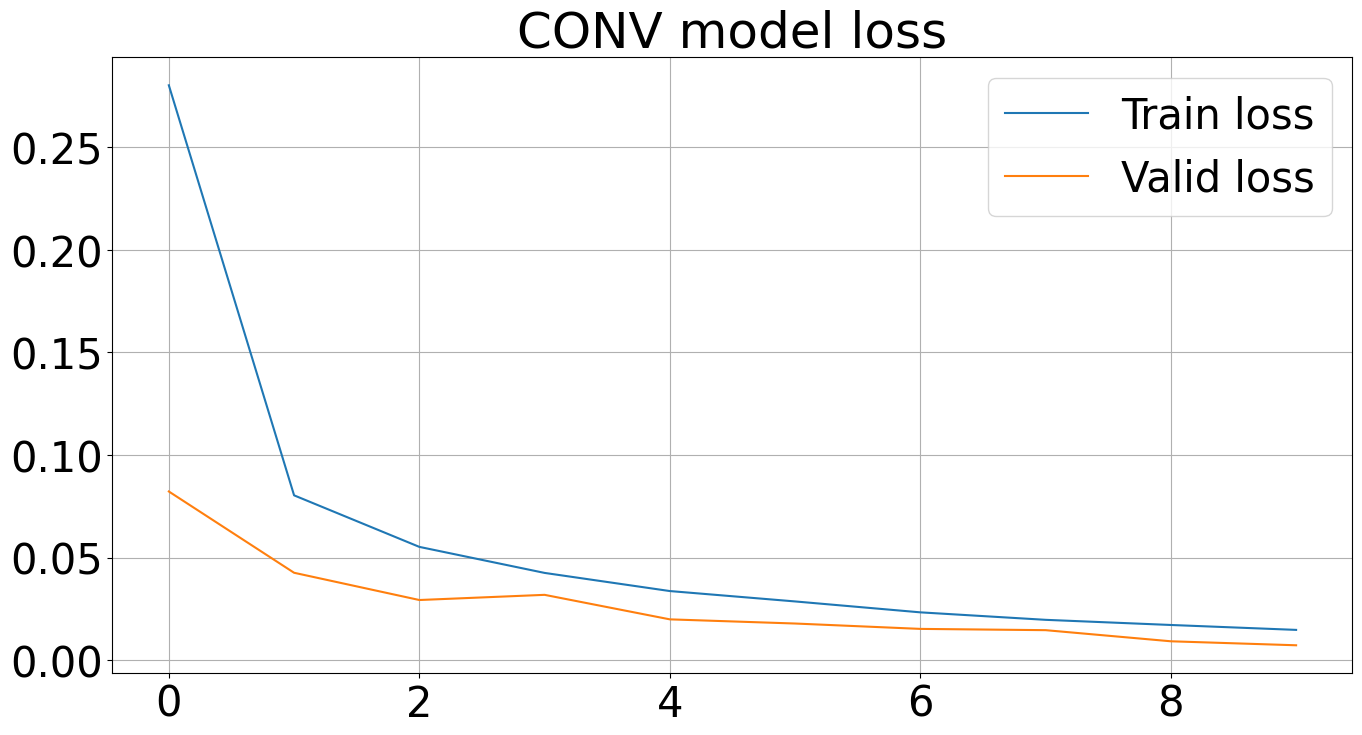

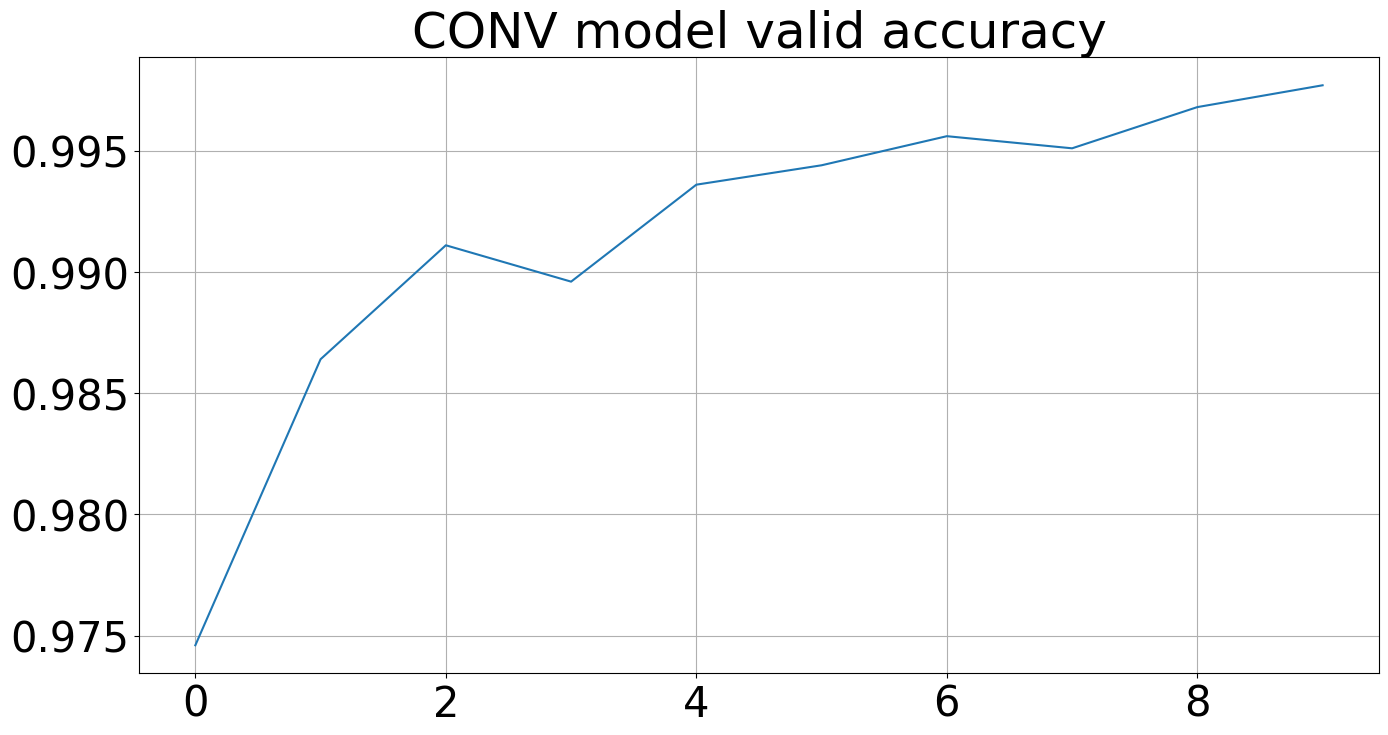

Total training and evaluation time 54.93205


In [61]:
num_epochs = 10

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(second_model_del_maxpool)

    valid_loss, valid_accuracy = evaluate(second_model_del_maxpool, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'CONV model')

print(f'Total training and evaluation time {perf_counter() - start:.5f}')